XG Boost
=======

Libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from scipy.stats import randint as sp_randint
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix,\
                            precision_recall_fscore_support, auc, accuracy_score

from scipy import interp

#### Read Data:

In [2]:
data = pd.read_csv("/media/juanan/DATA/loan_data_analysis/data/loans_processed.csv", sep = "^")\
                   .sample(200000)

In [3]:
data = data.reset_index()
data = data.drop("index", axis = 1)

In [4]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,2.0,3.0,B,5715.0,0.0,3.0,0.0,14900.0,0.0,34291.0,...,0.0,25068.0,74.3,50.0,B2,0.0,3.0,6.23,RENT,0.0
1,4.0,2.0,B,3496.0,0.0,7.0,0.0,13825.0,0.0,24474.0,...,0.0,21044.0,41.2,25.0,B5,0.0,5.0,28.10,RENT,1.0
2,2.0,5.0,C,1795.0,0.0,10.0,0.0,8000.0,0.0,10772.0,...,0.0,6165.0,50.4,50.0,C5,1.0,5.0,13.17,RENT,0.0
3,3.0,3.0,C,71678.0,0.0,7.0,0.0,35000.0,0.0,51828.0,...,2.0,71302.0,9.1,0.0,C5,4.0,3.0,8.50,MORTGAGE,1.0
4,3.0,4.0,C,27824.0,0.0,13.0,0.0,17000.0,3.0,25393.0,...,0.0,8095.0,67.7,66.7,C5,4.0,6.0,7.22,OWN,0.0


In [5]:
data.shape

(200000, 50)

Data balance:

In [6]:
data['loan_status'].value_counts()

0.0    158785
1.0     41215
Name: loan_status, dtype: int64

#### Pre-processing:

Categorical_variables:

In [7]:
categorical_variables = data.select_dtypes(include="object").columns

In [8]:
def categorical_to_numeric(variable):
    
    variable_dict = dict(data.groupby(variable)['loan_status'].mean())
    
    result = data[variable].map(lambda i: variable_dict[i])
    
    return result

In [9]:
for variable in categorical_variables:
    data[variable] = categorical_to_numeric(variable)

In [10]:
data.head()

,num_bc_sats,num_rev_tl_bal_gt_0,grade,avg_cur_bal,pub_rec_bankruptcies,num_rev_accts,tax_liens,funded_amnt_inv,delinq_2yrs,total_bal_ex_mort,...,num_accts_ever_120_pd,total_il_high_credit_limit,bc_util,percent_bc_gt_75,sub_grade,mort_acc,num_op_rev_tl,dti,home_ownership,loan_status
0,2.0,3.0,0.135748,5715.0,0.0,3.0,0.0,14900.0,0.0,34291.0,...,0.0,25068.0,74.3,50.0,0.115926,0.0,3.0,6.23,0.238605,0.0
1,4.0,2.0,0.135748,3496.0,0.0,7.0,0.0,13825.0,0.0,24474.0,...,0.0,21044.0,41.2,25.0,0.172592,0.0,5.0,28.10,0.238605,1.0
2,2.0,5.0,0.222361,1795.0,0.0,10.0,0.0,8000.0,0.0,10772.0,...,0.0,6165.0,50.4,50.0,0.253410,1.0,5.0,13.17,0.238605,0.0
3,3.0,3.0,0.222361,71678.0,0.0,7.0,0.0,35000.0,0.0,51828.0,...,2.0,71302.0,9.1,0.0,0.253410,4.0,3.0,8.50,0.179166,1.0
4,3.0,4.0,0.222361,27824.0,0.0,13.0,0.0,17000.0,3.0,25393.0,...,0.0,8095.0,67.7,66.7,0.253410,4.0,6.0,7.22,0.210659,0.0


In [11]:
data.shape

(200000, 50)

Target:

In [12]:
X = data.loc[:, data.columns!='loan_status']
X = X.values

In [13]:
y = data['loan_status']

XG Boost:
======
__________

In [14]:
xg_boost = xgb.XGBClassifier(n_estimators=50)

Parameters to randomize:

In [15]:
xg_params = {'max_depth': [6, 10, 15, 20],
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
             'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'gamma': [0, 0.25, 0.5, 1.0],
             'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]}

Randomize search with Cross Validation:

In [16]:
random_search = RandomizedSearchCV(xg_boost, n_iter=50, param_distributions=xg_params,
                                   cv=3, scoring="roc_auc", n_jobs=2, verbose=1)

In [17]:
random_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 57.2min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed: 135.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=50, n_jobs=2,
          param_distributions={'max_depth': [6, 10, 15, 20], 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3], 'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0], 'gamma': [0, 0.25, 0.5, 1.0], 'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_tr

__Cross Validation Results:__

In [18]:
pd.set_option('display.max_columns', None)
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bylevel,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_reg_lambda,param_subsample,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,87.012082,0.919702,0.809221,0.833389,0.7,1,0.25,0.2,6,3,0.1,0.6,"{'subsample': 0.6, 'reg_lambda': 0.1, 'min_chi...",8,0.810891,0.832396,0.806961,0.834686,0.809809,0.833084,2.614233,0.108555,0.001657,9.594335e-04
1,403.181967,6.646152,0.797678,1.000000,0.9,0.8,0.25,0.1,20,1,0.1,0.9,"{'subsample': 0.9, 'reg_lambda': 0.1, 'min_chi...",23,0.799018,1.000000,0.796164,1.000000,0.797851,1.000000,5.930421,0.088675,0.001172,1.216022e-08
2,159.177318,1.735757,0.610962,0.639990,0.9,0.6,1,3,15,0.5,5,1,"{'subsample': 1.0, 'reg_lambda': 5.0, 'min_chi...",39,0.624875,0.646596,0.606366,0.628761,0.601643,0.644614,8.700779,0.130487,0.010026,7.981662e-03
3,82.871535,0.700718,0.794695,0.798951,0.8,0.7,1,0.001,6,10,0.1,0.5,"{'subsample': 0.5, 'reg_lambda': 0.1, 'min_chi...",28,0.798960,0.799513,0.790089,0.799531,0.795037,0.797807,8.738988,0.045945,0.003630,8.087093e-04
4,157.572110,1.400647,0.500000,0.500000,0.5,1,0.25,0,15,7,50,0.6,"{'subsample': 0.6, 'reg_lambda': 50.0, 'min_ch...",45,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,6.409673,0.116079,0.000000,0.000000e+00
5,120.501391,2.356158,0.500000,0.500000,0.4,0.9,0,0,10,3,0.1,1,"{'subsample': 1.0, 'reg_lambda': 0.1, 'min_chi...",45,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,10.981800,0.258463,0.000000,0.000000e+00
6,96.388529,1.975124,0.803038,0.888144,0.4,0.7,0,0.2,10,5,0.1,0.6,"{'subsample': 0.6, 'reg_lambda': 0.1, 'min_chi...",15,0.804261,0.887759,0.799864,0.888947,0.804989,0.887725,14.636485,0.499084,0.002264,5.682845e-04
7,170.971498,1.765541,0.800023,0.842590,0.8,0.7,0.5,0.001,10,3,0.1,0.9,"{'subsample': 0.9, 'reg_lambda': 0.1, 'min_chi...",19,0.800185,0.842920,0.797989,0.843302,0.801894,0.841549,6.270624,0.277171,0.001598,7.524598e-04
8,228.323565,1.714547,0.797743,0.813310,1,0.7,0.5,0.001,15,10,10,0.5,"{'subsample': 0.5, 'reg_lambda': 10.0, 'min_ch...",22,0.794619,0.808604,0.796992,0.816196,0.801617,0.815129,2.523707,0.087220,0.002906,3.355603e-03
9,101.727195,0.989783,0.623252,0.629208,0.9,0.8,0.5,3,6,0.5,100,0.6,"{'subsample': 0.6, 'reg_lambda': 100.0, 'min_c...",38,0.659351,0.667351,0.525411,0.531687,0.684992,0.688587,1.658579,0.137998,0.069971,6.950080e-02


In [19]:
random_search.best_params_

{'colsample_bylevel': 0.6,
 'colsample_bytree': 0.5,
 'gamma': 0.5,
 'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 7.0,
 'reg_lambda': 100.0,
 'subsample': 1.0}

In [20]:
random_search.best_score_

0.8108538016814639

Feature importance:

Text(0.5,1,'Feature importance')

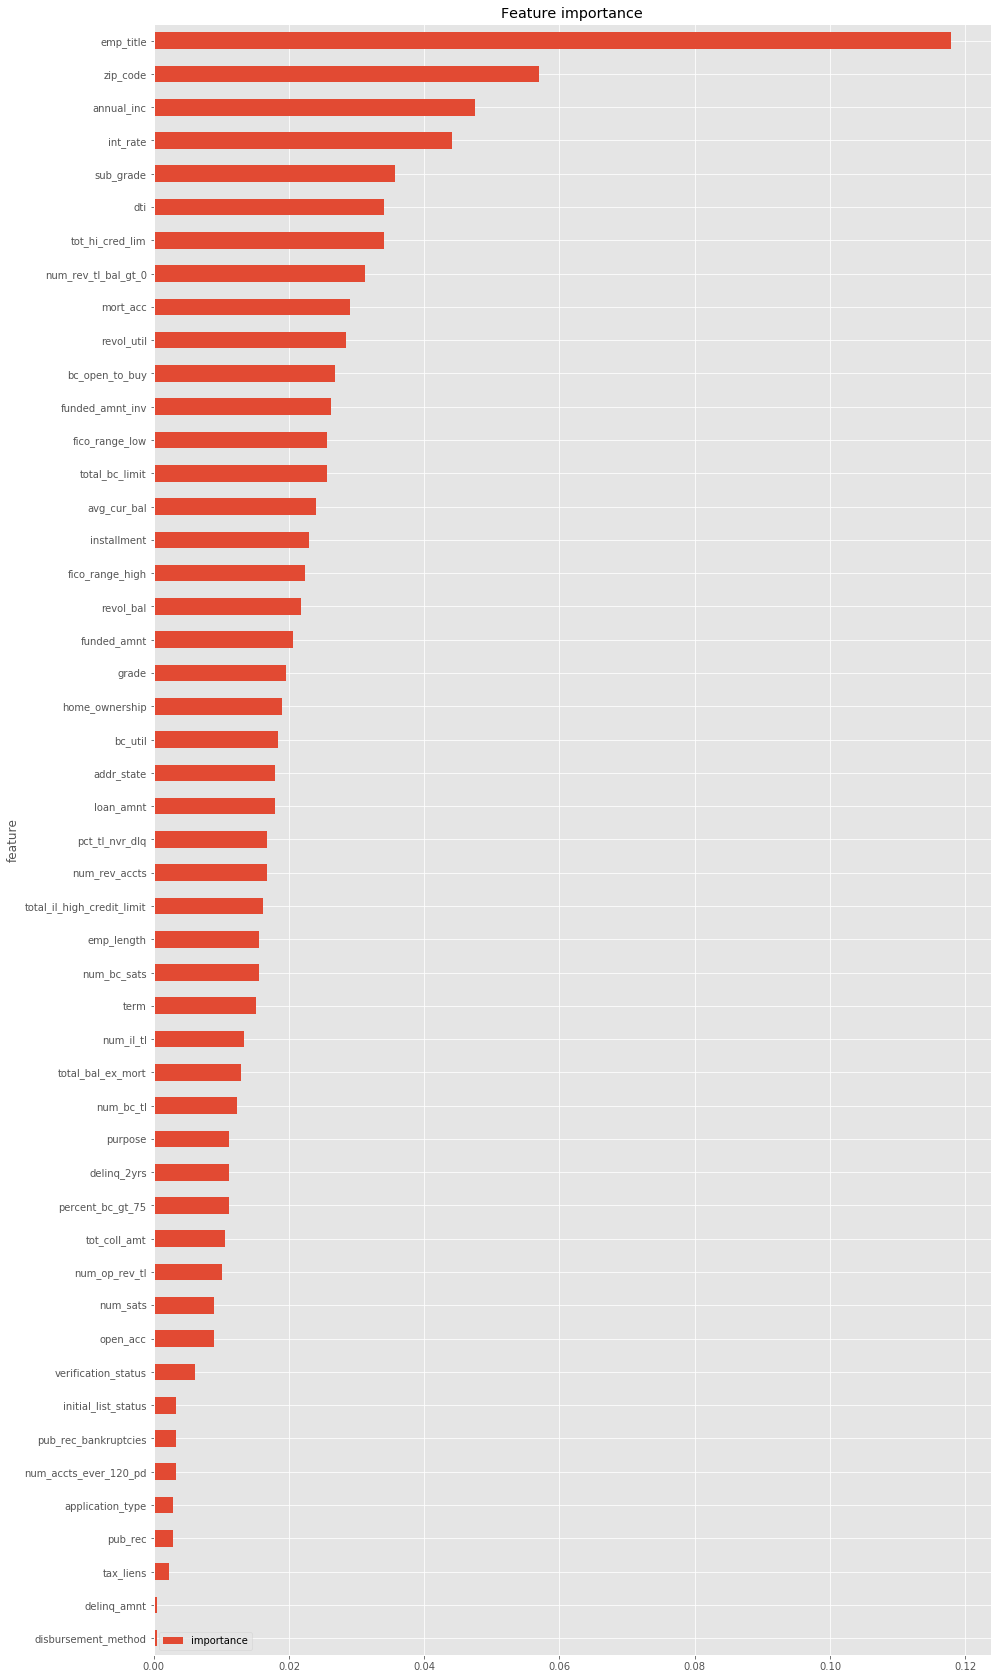

In [21]:
features = pd.DataFrame({'feature':data.loc[:, data.columns!='loan_status'].columns,
                         'importance':random_search.best_estimator_.feature_importances_})

features = features.set_index('feature').sort_values('importance', ascending=True)

features.plot(kind='barh',figsize=(15,30)).set_title('Feature importance')

In this case, `emp_title` is still the most important feature for predicting `loan_status` although with less difference with regard to random forest model. Therefore, the feature engineering made has had good performance in both models.

Model Evaluation
==========
_________________

Run classifier with cross-validation and plot __ROC curves__:

In [22]:
cv = StratifiedKFold(n_splits=5)
classifier = xgb.XGBClassifier(colsample_bylevel=0.6, colsample_bytree=0.5, gamma=0.5,
                               learning_rate=0.2, max_depth=6, min_child_weight=7,
                               reg_lambda=100, subsample=1, n_estimators=200)

In [23]:
# dataframes to numpy arrays
y = y.values

The following source code to plot ROC curves have been downloaded from [sklearn API](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) with some metrics have been added for each cross validation split:

/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/juanan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is a

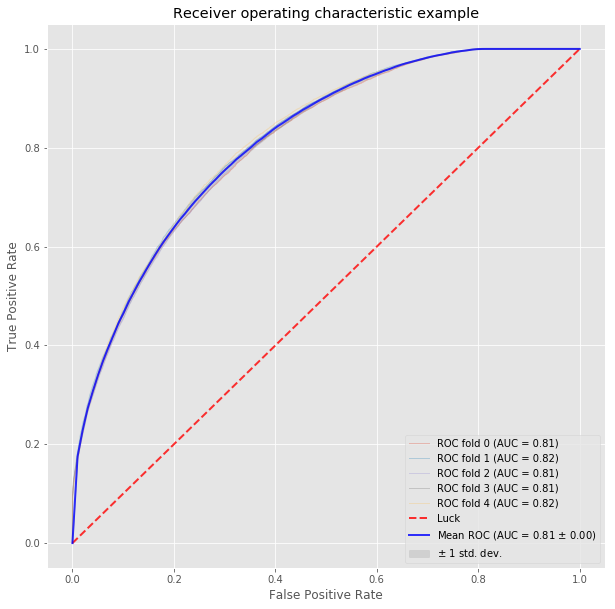

In [24]:
tprs = []
aucs = []
accuracies = []
precisions = []
recalls = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

i = 0
for train, test in cv.split(X, y):
    classifier.fit(X[train], y[train])
    probas_ = classifier.predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    # accuracy
    predictions_ = classifier.predict(X[test])
    accuracy = accuracy_score(y[test], predictions_)
    accuracies.append(accuracy)
    
    # precisions
    precision = precision_recall_fscore_support(y[test], predictions_)[0][1]
    precisions.append(precision)
    
    # recall
    recall = precision_recall_fscore_support(y[test], predictions_)[1][1]
    recalls.append(recall)
    
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

__Metrics__ in the test set:

In [25]:
metrics = pd.DataFrame(
    {"auc": aucs,
     "accuracy": accuracies, 
     "precision": precisions, 
     "recall": recalls
    })

In [26]:
metrics

,accuracy,auc,precision,recall
0,0.824875,0.810291,0.683136,0.280116
1,0.827975,0.817431,0.705989,0.283149
2,0.824975,0.810922,0.684273,0.279753
3,0.825875,0.813370,0.694343,0.276962
4,0.826600,0.818367,0.688166,0.289943


In [27]:
metrics.apply(lambda i: np.mean(i), axis = 0)

accuracy     0.826060
auc          0.814076
precision    0.691181
recall       0.281985
dtype: float64